In [ ]:
!pip install transformers

In [3]:
import pickle
import pandas as pd
import numpy as np
import csv
import time
import torch
from torchtext.legacy import data 
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
# this should be changed depending the address for you
os.chdir('/content/drive/MyDrive/LTP - myside/') 

## using cuda if available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

def read_pickle_file(filename):
    with open(filename, 'rb') as f:
        x = pickle.load(f)

    return x
X_train = read_pickle_file("./data/X_train.pickle")
X_test = read_pickle_file("./data/X_test.pickle")
y_train = read_pickle_file("./data/y_train.pickle")
y_test = read_pickle_file("./data/y_test.pickle")


#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

d = {'text':X_train,'label':y_train}
train_df = pd.DataFrame(d)
train_df = train_df.sample(frac = 1, random_state=SEED)
print(train_df)
train_df.to_csv(r'train.csv')

Mounted at /content/drive
                                                    text  label
4381   Look Before You Leap, But Having Leapt Never L...      0
11946  In the struggle , the building catches fire an...      0
1996   The History Channel +1. Where History repeats ...      1
10488  It has a subdorsal row of white spots ringed w...      0
5674   Arab-Israeli lawmakers suspended for meeting f...      0
...                                                  ...    ...
4286              He That Will Thrive, Must Rise At Five      0
12069  Three of its number 1 hits , `` End of the Roa...      0
11423  Born in 1048 CE and originating from Nisa , he...      0
10610  However , stream ciphers can be susceptible to...      0
7240   Proposals to keep Britain in EU unveiled, but ...      0

[13409 rows x 2 columns]


In [ ]:
print(type(X_train[0]))
print(type(y_train[0]))

<class 'numpy.str_'>
<class 'int'>


In [ ]:
with open('train.csv', 'r') as file:
    reader = csv.reader(file)
    row_count = sum(1 for row in reader)
    print(row_count)


X_train = []
y_train = []
X_eval = []
y_eval = []

with open('train.csv', 'r') as file:
    reader = csv.reader(file)
    row_num = 0
    for row in reader:
      # print(row_num)
      if row_num == 0:
        print(f'Column names are {", ".join(row)}')
      elif row_num < 0.8*row_count:
        X_train.append(row[1])
        y_train.append(int(row[2]))
      else:
        X_eval.append(row[1])
        y_eval.append(int(row[2]))
      row_num += 1
        


In [ ]:
print(type(X_train[0]))
print(type(y_train[0]))
print(X_train)
print(y_train)

print(X_train[0])
print(y_train[0])

In [ ]:
print(type(X_eval[0]))
print(type(y_eval[0]))
print(X_eval)
print(y_eval)

print(X_eval[0])
print(y_eval[0])

In [5]:
class HumorDataset(Dataset):
  def __init__(self, text_data, input_labels, tokenizer):
        super().__init__()
        
        data = []
        labels = []
        ## to be changed if needed
        ## to be changed if needed
        max_length = 207
        self.max_length = max_length

        for i, sample in enumerate(text_data):
          tokens = tokenizer.tokenize(sample)
          data_idxs = tokenizer.encode(sample)
          
          padded = np.zeros(max_length)
          if max_length < 207 and len(data_idxs) > max_length:
            padded = data_idxs[:max_length]
          else:
            padded[:len(data_idxs)] = data_idxs
          
          data.append(padded)
          
          labels.append(input_labels[i])
          
        self.data = torch.tensor(data, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

  def __getitem__(self, index):
        return self.data[index], self.labels[index]

  def __len__(self):
        return len(self.data)

In [6]:
pretrained = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained)
tokenizer.do_basic_tokenize = False

In [7]:
#set batch size
BATCH_SIZE = 64

In [8]:
train_dataset = HumorDataset(X_train, y_train, tokenizer)

In [9]:
train_loader = DataLoader(train_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)

In [11]:
class NN(nn.Module):
    """ The neural network that will be used """

    def __init__(self, vocab_size, input_dim, output_dim, embedding_size=100):
        """
        Args:
            input_dim (int): size of the input features
            vocab_size : vocabulary size
            output_dim (int): number of classes
        """
        

        super(NN, self).__init__()

        # model architecture
        

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        
        ## just for concatenation method - if using other methods in the forward section, comment the following line
        # embedding_size = input_dim*embedding_size

        ## one layer network
        # self.fc1 = nn.Linear(embedding_size, output_dim)

        # multilayer network - in this case comment the prevous line and uncomment the following
        # I used them but they don't increase the accuracy significanlty
        self.fc1 = nn.Linear(embedding_size, 32)
        self.fc2 = nn.Linear(32, output_dim)
        # self.fc3 = nn.Linear(32, output_dim)
        

        # self.fc1 = nn.Linear(embedding_size, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, 32)
        # self.fc4 = nn.Linear(32, output_dim)
        # self.fc3 = nn.Linear(300, 100)
        # self.fc4 = nn.Linear(100, output_dim)

        self.embedding_size = embedding_size
        
        

    def forward(self, x):
        """The forward pass of the NN

        Args:
            x (torch.Tensor): an input data tensor. 
                x.shape should be (batch_size, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch_size, num_classes)
        """

        ## here are several methods for embedding layer
        ## for method "sum" got accuracy 0.7563 after 10 epochs
        # x_embedded_sum = self.embedding(x).sum(dim=1)

        ## for "mean" got accuracy 0.7773 after 10 epochs
        x_embedded = self.embedding(x).mean(dim=1)
        
        ## for "concat" got accuracy 0.8336 after 7 epochs and then decreased - still the highest I got! so I kept it!
        # x_embedded = self.embedding(x).view(100, self.embedding_size)

        x = self.fc1(x_embedded)
        
        # multilayer network - in this case comment the prevous line and uncomment the following
        x = torch.relu(x)
        x = self.fc2(x)
        # x = torch.tanh(x)
        # x = self.fc3(x)
        # x = torch.tanh(x)
        # x = self.fc4(x)


        x = torch.sigmoid(x)
        
        return x
    
    def print_params(self):
        """Print the parameters (theta) of the network. Mainly for debugging purposes"""
        for name, param in model.named_parameters():
            print(name, param.data)

In [82]:
print(train_dataset.labels)
print(train_dataset.labels.shape)

tensor([0, 0, 1,  ..., 0, 1, 0])
torch.Size([10727])


In [71]:
from tensorflow import reduce_max
vocab_size = reduce_max(train_dataset.data)
print(vocab_size)

tf.Tensor(30064, shape=(), dtype=int64)


In [12]:
#define hyperparameters
size_of_vocab = 30065
embedding_dim = 100
num_output_nodes = 1

# instantiate the model
model = NN(size_of_vocab, 50, num_output_nodes, embedding_dim)

In [13]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

NN(
  (embedding): Embedding(30065, 100)
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)
The model has 3,009,765 trainable parameters


In [14]:
#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    correct = 0.0
    total = 0.0
    for k in range (0, len(y)):
      output = torch.round(preds[k])
      
      if output==y[k]:
        correct += 1
    acc = correct/len(y)
    return acc
    
#push to cuda if available
# model = model.to(device)
# criterion = criterion.to(device)

In [87]:
def train(model, iterator, optimizer):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()

    for i, batch in enumerate(iterator):
        data, labels = batch

        optimizer.zero_grad() 
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)

        #compute the loss
        loss = criterion(outputs.squeeze(), labels.float())        
        
        #compute the binary accuracy
        acc = binary_accuracy(outputs, labels)
 
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss
        epoch_acc += acc
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [16]:
def evaluate(model, iterator):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            data, labels = batch
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            
            #compute loss and accuracy
            loss = criterion(outputs.squeeze(), labels.float())
            acc = binary_accuracy(outputs, labels)
            
            #keep track of loss and accuracy
            epoch_loss += loss
            epoch_acc += acc
        

    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [145]:
N_EPOCHS = 5
best_valid_loss = float('inf')
## pushing to cuda
model = model.to(device)  

eval_dataset = HumorDataset(X_eval, y_eval, tokenizer)
eval_loader = DataLoader(eval_dataset,
      shuffle=True,
      batch_size=BATCH_SIZE)

for epoch in range(N_EPOCHS):
     
    
    # store starting time (training)
    begin = time.time()

    #train the model
    train_loss, train_acc = train(model, train_loader, optimizer)

    # store end time (training)
    end = time.time()

    # print train time
    print(f"Train time is {end - begin}")
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, eval_loader)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_ff.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Train time is 1.845066785812378
	Train Loss: 0.619 | Train Acc: 68.43%
	 Val. Loss: 0.609 |  Val. Acc: 69.62%
Train time is 1.8465771675109863
	Train Loss: 0.409 | Train Acc: 81.01%
	 Val. Loss: 0.161 |  Val. Acc: 94.59%
Train time is 1.865164041519165
	Train Loss: 0.139 | Train Acc: 95.13%
	 Val. Loss: 0.132 |  Val. Acc: 95.16%
Train time is 1.8253333568572998
	Train Loss: 0.115 | Train Acc: 95.63%
	 Val. Loss: 0.208 |  Val. Acc: 92.46%
Train time is 1.837141752243042
	Train Loss: 0.106 | Train Acc: 96.10%
	 Val. Loss: 0.166 |  Val. Acc: 94.02%


In [17]:
#load weights
path='saved_weights_ff.pt'
model.load_state_dict(torch.load(path));
model = model.to(device) 

test_dataset = HumorDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset,
      shuffle=True,
      # collate_fn=padding_collate_fn,
      batch_size=BATCH_SIZE)

test_loss, test_acc = evaluate(model, test_loader)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Test Loss: 0.157 | Test Acc: 94.80%


[[2270   34]
 [ 141  910]]


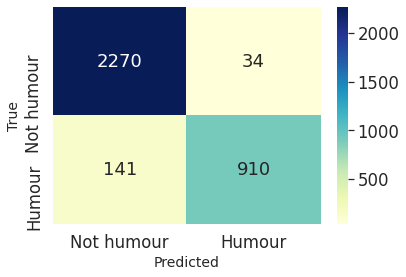

In [19]:
from sklearn.metrics import confusion_matrix

def confusion_mat(model, iterator):
    
    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():

      #initializing confusion matrix
      cm = [[0,0],[0,0]]

      for i, batch in enumerate(iterator):
          data, labels = batch
          data = data.to(device)
          labels = labels.to(device)

          #get outputs
          outputs = model(data)
          y_pred = torch.round(outputs.squeeze())
          


          #add this batch to confusion matrix
          cm += confusion_matrix(labels.float().cpu(), y_pred.cpu())

    return cm


cf_matrix = confusion_mat(model, test_loader)
print(cf_matrix)

import seaborn as sn
import matplotlib.pyplot as plt

classes = ["Not humour", "Humour"]

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
# plt.figure(figsize = (12,7))
plt.figure(figsize = (6,4))
sn.set(font_scale=1.5)
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel("Predicted", fontsize = 14)
plt.ylabel("True", fontsize = 14)
plt.savefig('ff_hooof1.png')